<a href="https://colab.research.google.com/github/MUKESHRAJMAHENDRAN/Deep-Learning--fastai/blob/main/Web_application_to_classify_greats_apes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image classification using deep learning

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 197 kB 31.2 MB/s 
     |████████████████████████████████| 60 kB 8.9 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *

In [3]:
from fastai.vision.widgets import *

In [4]:
!pip install fastbook

     |████████████████████████████████| 719 kB 35.6 MB/s 
     |████████████████████████████████| 1.2 MB 52.6 MB/s 


In [5]:
from fastbook import *

In [6]:
from fastbook import *
urls = search_images_ddg('chimpanzee', max_images=100)
len(urls),urls[0]

(100,
 'https://www.achieveglobalsafaris.com/wp-content/uploads/2019/10/Chimpanzee.jpg')

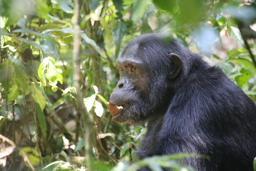

In [7]:
download_url(urls[0], 'images/ape.jpg')
im = Image.open('images/ape.jpg')
im.thumbnail((256,256))
im

In [8]:
!ls

images	sample_data


In [9]:
ape_types = 'chimpanzee','bonobos','gorilla'
path = Path('ape')

In [10]:
!rm -rf ape

In [11]:
from tqdm import tqdm
if not path.exists():
    path.mkdir()
    for o in tqdm(ape_types):
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} ape', max_images=100)
        download_images(dest, urls=results)

100%|██████████| 3/3 [00:57<00:00, 19.01s/it]


In [12]:
fns = get_image_files(path)
fns

(#264) [Path('ape/gorilla/00000073.png'),Path('ape/gorilla/00000052.jpg'),Path('ape/gorilla/00000082.jpeg'),Path('ape/gorilla/00000012.jpg'),Path('ape/gorilla/00000028.jpg'),Path('ape/gorilla/00000067.jpg'),Path('ape/gorilla/00000058.jpg'),Path('ape/gorilla/00000007.jpg'),Path('ape/gorilla/00000092.jpg'),Path('ape/gorilla/00000074.jpg')...]

In [13]:
fns[0]

Path('ape/gorilla/00000073.png')

In [14]:
failed = verify_images(fns)
failed

(#1) [Path('ape/bonobos/00000001.jpg')]

In [15]:
failed.map(Path.unlink);

In [16]:
ape = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = ape.dataloaders(path)

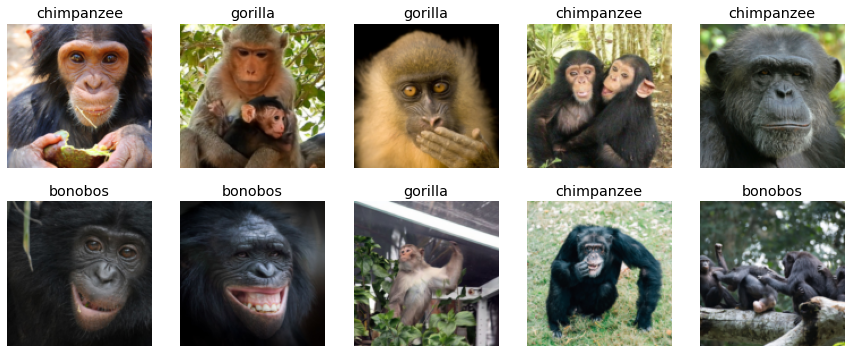

In [18]:
dls.valid.show_batch(max_n=10, nrows=2)

In [19]:
ape = ape.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = ape.dataloaders(path)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.924602,1.104800,0.519231,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.190233,0.810039,0.384615,00:12
1,1.135509,0.695203,0.288462,00:13
2,1.004064,0.610733,0.211538,00:14
3,0.914051,0.603506,0.230769,00:12
4,0.825811,0.605862,0.211538,00:13
5,0.730178,0.610586,0.173077,00:12
6,0.664554,0.592050,0.192308,00:13
7,0.609201,0.580650,0.173077,00:13
8,0.549764,0.583735,0.153846,00:12
9,0.495776,0.585111,0.153846,00:12


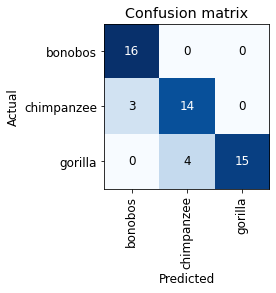

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

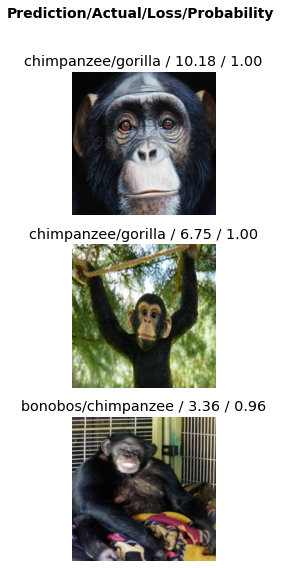

In [22]:
interp.plot_top_losses(3, nrows=3)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner


In [24]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [26]:
learn.predict("/content/download.jpeg")

('bonobos', TensorBase(0), TensorBase([9.9882e-01, 1.1679e-03, 1.5527e-05]))

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict("/content/image.jpg")

('chimpanzee', TensorBase(1), TensorBase([9.3904e-04, 9.9896e-01, 1.0253e-04]))

In [32]:
learn_inf.dls.vocab

['bonobos', 'chimpanzee', 'gorilla']

In [44]:
!pip install -q gradio

     |████████████████████████████████| 2.9 MB 32.9 MB/s 
     |████████████████████████████████| 212 kB 75.3 MB/s 
     |████████████████████████████████| 2.0 MB 62.5 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 67.8 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 253 kB 67.0 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 75.0 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 271 kB 74.0 MB/s 
     |████████████████████████████████| 10.9 MB 63.8 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 79 kB 9.7 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 4.0 MB 60.6 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |███████████████████████

In [45]:
learn_inf.dls.vocab

['bonobos', 'chimpanzee', 'gorilla']

In [46]:
import gradio as gr
labels = ['bonobos', 'chimpanzee', "gorilla"]
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn_inf.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

/usr/local/lib/python3.7/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [48]:
gr_interface = gr.Interface(fn=predict, inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=len(labels)), interpretation="default")
gr_interface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://39211.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fc2d1f498d0>,
 'http://127.0.0.1:7860/',
 'https://39211.gradio.app')